# Building permutation invariant Sparse GPs

Okay, so the final piece of the puzzle regarding extending the PIICM is dealing with the invariance. Remember that in the original PIICM model, the GP was a function of 5 parameters
$$
f(c,A,B,x_A,x_B),
$$
the cell line $c$, the drugs $A$ and $B$ and the corresponding concentrations $x_A$ and $x_B$. The PIICM was invariant to the ordering of the drugs and their concentrations, so the following equality was enforced

$$
f(c,A,B,x_A,x_B)=f(c,B,A,x_B,x_A).
$$

This is done by constructing the GP via a summation. Construct the function $f()$ as the sum of evaluations of another function $\tilde{f}()$ like so:

$$
f(c,A,B,x_A,x_B) = \tilde{f}(c,A,B,x_A,x_B) + \tilde{f}(c,B,A,x_B,x_A),
$$
then placing a GP prior on $\tilde{f}$ induces a GP prior on $f$ itself since GPs are closed under summations. Note that the mapping of inputs $(c,A,B,x_A,x_B)\mapsto (c,B,A,x_B,x_A)$ leaves the function $f$ unchanged. If $\tilde{f}\sim\mathcal{GP}(0,\tilde{\kappa}(\cdot,\cdot))$, the induced GP prior has a covariance function

$$
\begin{align}
\text{Cov}\left[f(c,A,B,x_A,x_B),f(c',A',B',x'_A,x'_B)\right]  &= 
\text{Cov}[\tilde{f}(c,A,B,x_A,x_B) + \tilde{f}(c,B,A,x_B,x_A),\tilde{f}(c',A',B',x'_A,x'_B) + \tilde{f}(c',B',A',x'_B,x'_A)] \\
&=\text{Cov}\left[\tilde{f}(c,A,B,x_A,x_B),\tilde{f}(c',A',B',x'_A,x'_B)\right] + 
  \text{Cov}\left[\tilde{f}(c,A,B,x_A,x_B),\tilde{f}(c',B',A',x'_B,x'_A)\right] \\
  &+ 
  \text{Cov}\left[\tilde{f}(c,B,A,x_B,x_A),\tilde{f}(c',A',B',x'_A,x'_B)\right] + 
  \text{Cov}\left[\tilde{f}(c,B,A,x_B,x_A),\tilde{f}(c',B',A',x'_B,x'_A)\right] \\
&=\tilde{\kappa}((c,A,B,x_A,x_B),(c',A',B',x'_A,x'_B))+
  \tilde{\kappa}((c,A,B,x_A,x_B),(c',B',A',x'_B,x'_A))\\
  &+
  \tilde{\kappa}((c,B,A,x_B,x_A),(c',A',B',x'_A,x'_B))+
  \tilde{\kappa}((c,B,A,x_B,x_A),(c',B',A',x'_B,x'_A)).
\end{align}
$$

## Sparse approximation

When working with inducing points, we need to think of where to place them. In the case of invariant GPs, one can be quite efficient with them as symmetries are naturally built into the kernel. The key is to approximate $\tilde{f}$ with inducing variables and not $f$ itself. The question is how do we do this within the SVI framework in GPyTorch?

Placing inducing variables in $\tilde{f}$ (instead of $f$) is sometimes referred to as *inter-domain inducing variables* (see e.g. references by Mark van der Wilk and others [1](https://arxiv.org/pdf/2003.01115.pdf), [2](https://proceedings.neurips.cc/paper_files/paper/2018/file/d465f14a648b3d0a1faa6f447e526c60-Paper.pdf)). I might need to work through the maths here again to make sure I understand it. It needs specifying a slightly different bound, but it is essentially the same as the old one with some modification to the kernels.

From the programming side of things, I wonder if it is simply a matter of modifying the `forward` method of the underlying models, as presumably that's where the covariances are generated from. Curious to see how the bound is evaluated though, as e.g. $\text{Cov}[f(x),\tilde{f}(z)]$ would contain a "single sum", while $\text{Cov}[f(x),f(x')]$ would contain a "double sum" in the language of van der Wilk.

Specifically, if we assume $\tilde{f}$ is defined over some space $\mathcal{Z}$ and $f$ over the space $\mathcal{X}$ then

$$
\begin{align}
\text{Cov}[f(\mathbf{x}),f(\mathbf{x}')] &= \kappa(\mathbf{x},\mathbf{x}') + \kappa(\mathbf{x},\tilde{\mathbf{x}}') + \kappa(\tilde{\mathbf{x}},\mathbf{x}') + \kappa(\tilde{\mathbf{x}},\tilde{\mathbf{x}}') \\
\text{Cov}[f(\mathbf{x}),\tilde{f}(\mathbf{z}')] &= \kappa(\mathbf{x},\mathbf{z}') + \kappa(\tilde{\mathbf{x}},\mathbf{z}') \\
\text{Cov}[\tilde{f}(\mathbf{z}),\tilde{f}(\mathbf{z}')] &= \kappa(\mathbf{z},\mathbf{z}')
\end{align}
$$

I think the relevant piece of code in `VariationalStrategy.forward` is 

```{python}
# Compute full prior distribution
full_inputs = torch.cat([inducing_points, x], dim=-2)
full_output = self.model.forward(full_inputs, **kwargs)
full_covar = full_output.lazy_covariance_matrix
```

Which calls `forward` of the model (of class `ApproximateGP`), on both the inputs $X$ and the inducing locations $Z$. But these should now have a different covariance, so I need to modify this.

## A very basic Sparse GP implementation

Below I set up a very basic implementation of Sparse GPs with SVI. Basically, I just want to follow Hensman (2015) and get a framework up that I can experiment with. The function needs to be a function of two inputs, $f(x_1,x_2)$ and I'll try to enforce $f(x_1,x_2)=f(x_2,x_1)$ which will lead to symmetric contour plots.

With this restriction in place, it means the covariance of $f$ will take the form

$$
\kappa((x_1,x_2),(x_1',x_2')) = \kappa((x_1,x_2),(x_1',x_2')) + \kappa((x_1,x_2),(x_2',x_1')) + \kappa((x_2,x_1),(x_1',x_2')) + \kappa((x_2,x_1),(x_2',x_1'))
$$

I generate true data from this distribtution, but set up a vanilla SVI model to estimate it, not taking the invariance into account. In order to really visualize the failure of the GP to capture this, I'll furthermore simulate data very sparsely, making it difficult for the GP to learn the invariance simply through the data.

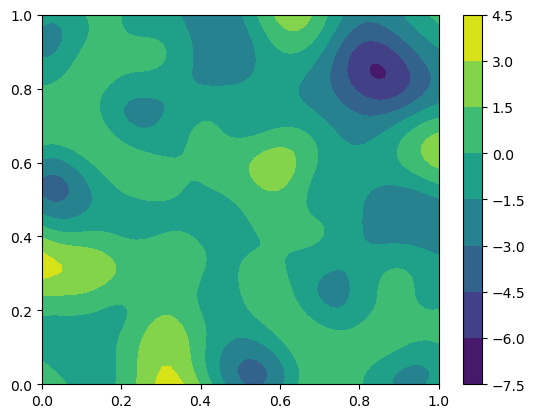

In [3]:
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

# Setting up the grid
n = 60
x1 = torch.linspace(0,1,n)
x2 = torch.linspace(0,1,n)
x1_grid, x2_grid = torch.meshgrid(x1,x2,indexing='ij')
X1 = x1_grid.reshape(-1)
X2 = x2_grid.reshape(-1)
X = torch.stack([X1,X2],dim=-1)
X_flipped = torch.stack([X2,X1],dim=-1)

# Generating a random sample from a GP
mean = gpytorch.means.ZeroMean()
covar = gpytorch.kernels.RBFKernel()
covar.lengthscale = 0.1
m = mean(X)
K = (covar(X,X) + covar(X,X_flipped) + covar(X_flipped,X) + covar(X_flipped,X_flipped)).add_jitter().evaluate()
GP = gpytorch.distributions.MultivariateNormal(m,K)
f = GP.rsample().detach()


# Now generate some corresponding data
sigma = 0.01
y = f + sigma*torch.randn(f.size())


# Finally, going to drop a proportion of the data just to ensure the grid structure is broken and 
# the model will find it difficult to learn the exact invariance.
k = 2000
perm = torch.randperm(y.size(0))
idx = perm[:k]
y = y[idx]
X = X[idx,:]


plt.contourf(x1_grid.numpy(),x2_grid.numpy(),f.reshape(x1_grid.shape))
plt.colorbar()



In [4]:
# And now define the approximate model, nothing invariant going on here
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(self,inducing_points,variational_distribution, learn_inducing_locations=True)
        super(GPModel,self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)
    
num_inducing_points = 100
inducing_points = torch.rand(num_inducing_points,2)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [5]:
# Set up optimization scheme

# Number of iterations of optimizer
training_iter = 4000

# Set model in train
model.train()
likelihood.train()
# Optimizeer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)
# Define loss function
mll = gpytorch.mlls.VariationalELBO(likelihood,model,num_data = y.size(0))

# Keeping track of loss
m = []
eps = 1e-4
diff = 10

# Then train
for i in range(training_iter):
    # Zero gradients
    optimizer.zero_grad()
    # Output from model 
    output = model(X)
    # Calculate loss
    loss = -mll(output,y)
    loss.backward()
    m.append(loss.item())
    if i > 0:
        diff = abs(m[i]-m[i-1])
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f loss difference: %.4f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        likelihood.noise.item(),
        diff
    ))
    optimizer.step()
    if diff < eps:
        print('Model converged!')
        break

Iter 1/4000 - Loss: 2.962   lengthscale: 0.693   noise: 0.693 loss difference: 10.0000
Iter 2/4000 - Loss: 2.919   lengthscale: 0.698   noise: 0.698 loss difference: 0.0433
Iter 3/4000 - Loss: 2.876   lengthscale: 0.695   noise: 0.703 loss difference: 0.0427
Iter 4/4000 - Loss: 2.834   lengthscale: 0.690   noise: 0.708 loss difference: 0.0419
Iter 5/4000 - Loss: 2.793   lengthscale: 0.686   noise: 0.713 loss difference: 0.0410
Iter 6/4000 - Loss: 2.753   lengthscale: 0.682   noise: 0.718 loss difference: 0.0400
Iter 7/4000 - Loss: 2.714   lengthscale: 0.677   noise: 0.724 loss difference: 0.0391
Iter 8/4000 - Loss: 2.676   lengthscale: 0.672   noise: 0.729 loss difference: 0.0384
Iter 9/4000 - Loss: 2.638   lengthscale: 0.668   noise: 0.734 loss difference: 0.0375
Iter 10/4000 - Loss: 2.602   lengthscale: 0.663   noise: 0.739 loss difference: 0.0365
Iter 11/4000 - Loss: 2.566   lengthscale: 0.658   noise: 0.744 loss difference: 0.0357
Iter 12/4000 - Loss: 2.531   lengthscale: 0.653   n

Iter 114/4000 - Loss: 1.604   lengthscale: 0.286   noise: 1.047 loss difference: 0.0013
Iter 115/4000 - Loss: 1.604   lengthscale: 0.281   noise: 1.049 loss difference: 0.0001
Iter 116/4000 - Loss: 1.606   lengthscale: 0.277   noise: 1.050 loss difference: 0.0026
Iter 117/4000 - Loss: 1.596   lengthscale: 0.273   noise: 1.052 loss difference: 0.0098
Iter 118/4000 - Loss: 1.593   lengthscale: 0.268   noise: 1.053 loss difference: 0.0036
Iter 119/4000 - Loss: 1.581   lengthscale: 0.264   noise: 1.055 loss difference: 0.0117
Iter 120/4000 - Loss: 1.575   lengthscale: 0.260   noise: 1.056 loss difference: 0.0067
Iter 121/4000 - Loss: 1.563   lengthscale: 0.256   noise: 1.057 loss difference: 0.0116
Iter 122/4000 - Loss: 1.555   lengthscale: 0.251   noise: 1.059 loss difference: 0.0079
Iter 123/4000 - Loss: 1.546   lengthscale: 0.247   noise: 1.060 loss difference: 0.0092
Iter 124/4000 - Loss: 1.538   lengthscale: 0.243   noise: 1.061 loss difference: 0.0081
Iter 125/4000 - Loss: 1.530   le

Iter 208/4000 - Loss: 1.006   lengthscale: 0.112   noise: 0.870 loss difference: 0.0029
Iter 209/4000 - Loss: 1.003   lengthscale: 0.113   noise: 0.865 loss difference: 0.0028
Iter 210/4000 - Loss: 1.000   lengthscale: 0.113   noise: 0.861 loss difference: 0.0028
Iter 211/4000 - Loss: 0.997   lengthscale: 0.113   noise: 0.857 loss difference: 0.0028
Iter 212/4000 - Loss: 0.995   lengthscale: 0.113   noise: 0.852 loss difference: 0.0027
Iter 213/4000 - Loss: 0.992   lengthscale: 0.113   noise: 0.848 loss difference: 0.0026
Iter 214/4000 - Loss: 0.989   lengthscale: 0.113   noise: 0.843 loss difference: 0.0028
Iter 215/4000 - Loss: 0.987   lengthscale: 0.113   noise: 0.839 loss difference: 0.0028
Iter 216/4000 - Loss: 0.984   lengthscale: 0.113   noise: 0.834 loss difference: 0.0027
Iter 217/4000 - Loss: 0.981   lengthscale: 0.113   noise: 0.830 loss difference: 0.0027
Iter 218/4000 - Loss: 0.978   lengthscale: 0.113   noise: 0.825 loss difference: 0.0028
Iter 219/4000 - Loss: 0.976   le

Iter 302/4000 - Loss: 0.721   lengthscale: 0.113   noise: 0.475 loss difference: 0.0024
Iter 303/4000 - Loss: 0.716   lengthscale: 0.113   noise: 0.471 loss difference: 0.0056
Iter 304/4000 - Loss: 0.712   lengthscale: 0.113   noise: 0.467 loss difference: 0.0033
Iter 305/4000 - Loss: 0.709   lengthscale: 0.113   noise: 0.464 loss difference: 0.0037
Iter 306/4000 - Loss: 0.704   lengthscale: 0.113   noise: 0.460 loss difference: 0.0044
Iter 307/4000 - Loss: 0.701   lengthscale: 0.113   noise: 0.457 loss difference: 0.0030
Iter 308/4000 - Loss: 0.697   lengthscale: 0.113   noise: 0.453 loss difference: 0.0045
Iter 309/4000 - Loss: 0.693   lengthscale: 0.113   noise: 0.449 loss difference: 0.0035
Iter 310/4000 - Loss: 0.689   lengthscale: 0.113   noise: 0.446 loss difference: 0.0037
Iter 311/4000 - Loss: 0.685   lengthscale: 0.113   noise: 0.442 loss difference: 0.0040
Iter 312/4000 - Loss: 0.682   lengthscale: 0.113   noise: 0.439 loss difference: 0.0037
Iter 313/4000 - Loss: 0.678   le

False


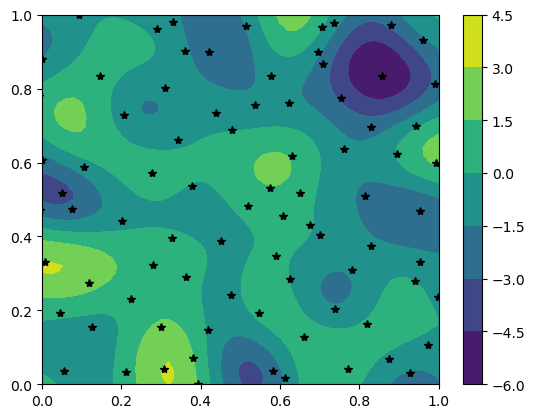

In [6]:
# Now making predictions on a finer grid
# Setting up the grid
n = 51
x1_test = torch.linspace(0,1,n)
x2_test = torch.linspace(0,1,n)
x1_test_grid, x2_test_grid = torch.meshgrid(x1_test,x2_test,indexing='ij')
X1_test = x1_test_grid.reshape(-1)
X2_test = x2_test_grid.reshape(-1)
X_test = torch.stack([X1_test,X2_test],dim=-1)
X_test_flipped = torch.stack([X2_test,X1_test],dim=-1)


# Get model into eval mode
model.eval()
likelihood.eval()

# Predicting
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))
    observed_pred_flipped = likelihood(model(X_test_flipped))


# Testing if predictions are equal
mean = observed_pred.mean
mean_flipped = observed_pred_flipped.mean
print(torch.equal(mean,mean_flipped)) # This returns False

# Plotting 
plt.contourf(x1_test_grid.numpy(),x2_test_grid.numpy(),mean.reshape(x1_test_grid.shape))
plt.colorbar()
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(model.variational_strategy.inducing_points.detach()[:,0],model.variational_strategy.inducing_points.detach()[:,1],'k*')

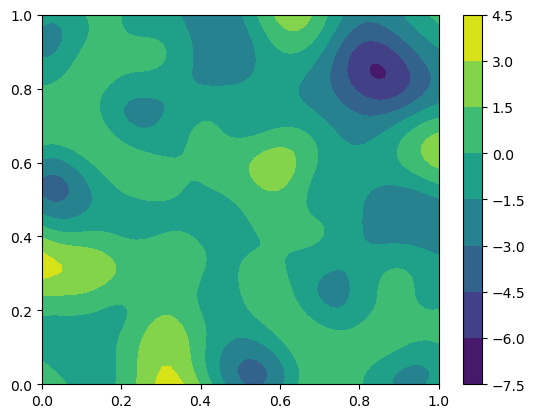

In [7]:
# Versus the true function

plt.contourf(x1_grid.numpy(),x2_grid.numpy(),f.reshape(x1_grid.shape))
plt.colorbar()

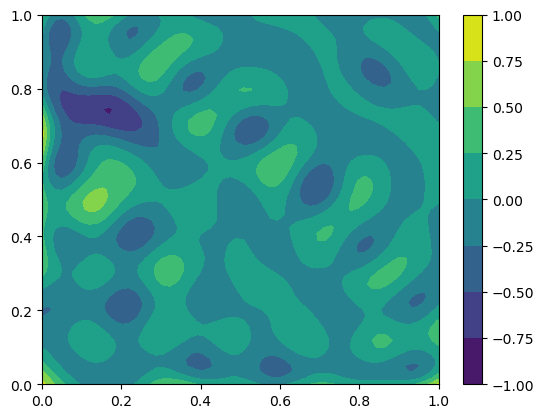

In [8]:
# And finally, let's look at the error surface
X_train_test = torch.stack([X1,X2],dim=-1)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_at_train = likelihood(model(X_train_test))

mean = test_at_train.mean
error = f-mean
plt.contourf(x1_grid.numpy(),x2_grid.numpy(),error.reshape(x1_grid.shape))
plt.colorbar()

## A first attempt at building in permutation invariance
Okay, so of course this does not work. While the model is flexible, and sometimes capable of learning the invariance itself, it is not strongly enforced. In order to do this, we need to modify the model to take this invariance into account. I need to understand how the invariance changes the ELBO and the variational distribution, and then I need to understand how to modify the corresponding terms in the `VariationalStrategy` or in the model itself.

In [9]:
# Lets first set up our own Variational Strategy, just so we can see the flow of things:
# just copy and paste in the default one with a new name:
from typing import  Any, Dict, Iterable, Optional, Tuple
from torch import Tensor
from linear_operator import to_dense
from linear_operator.operators import (
    CholLinearOperator,
    DiagLinearOperator,
    LinearOperator,
    MatmulLinearOperator,
    RootLinearOperator,
    SumLinearOperator,
    TriangularLinearOperator,
)
from linear_operator.utils.cholesky import psd_safe_cholesky
from linear_operator.utils.errors import NotPSDError
from gpytorch.distributions import MultivariateNormal
from gpytorch.settings import _linalg_dtype_cholesky, trace_mode

def _ensure_updated_strategy_flag_set(
    state_dict: Dict[str, Tensor],
    prefix: str,
    local_metadata: Dict[str, Any],
    strict: bool,
    missing_keys: Iterable[str],
    unexpected_keys: Iterable[str],
    error_msgs: Iterable[str],
):
    device = state_dict[list(state_dict.keys())[0]].device
    if prefix + "updated_strategy" not in state_dict:
        state_dict[prefix + "updated_strategy"] = torch.tensor(False, device=device)
        warnings.warn(
            "You have loaded a variational GP model (using `VariationalStrategy`) from a previous version of "
            "GPyTorch. We have updated the parameters of your model to work with the new version of "
            "`VariationalStrategy` that uses whitened parameters.\nYour model will work as expected, but we "
            "recommend that you re-save your model.",
            OldVersionWarning,
        )

class PermutationInvariantVariationalStrategy(gpytorch.variational.VariationalStrategy):
    def __init__(self,
        model: gpytorch.models.ApproximateGP,
        inducing_points: torch.Tensor,
        variational_distribution: gpytorch.variational._VariationalDistribution,
        learn_inducing_locations: bool = True,
        jitter_val: Optional[float] = None,
    ):
        super().__init__(
            model, inducing_points, variational_distribution, learn_inducing_locations, jitter_val=jitter_val
        )
        self.register_buffer("updated_strategy", torch.tensor(True))
        self._register_load_state_dict_pre_hook(_ensure_updated_strategy_flag_set)
        self.has_fantasy_strategy = True
    
    def forward(
        self,
        x: Tensor,
        inducing_points: Tensor,
        inducing_values: Tensor,
        variational_inducing_covar: Optional[LinearOperator] = None,
        **kwargs,
    ) -> MultivariateNormal:
        # Compute full prior distribution
        full_inputs = torch.cat([inducing_points, x], dim=-2)
        full_inputs_flipped = torch.cat([inducing_points, x.flip(-1)],dim=-2)
        full_inputs_flipped_flipped = torch.cat([x,x.flip(-1)],dim=-2)
        full_output = self.model.forward(full_inputs, **kwargs)
        full_output_flipped = self.model.forward(full_inputs_flipped, **kwargs)
        full_output_flipped_flipped = self.model.forward(full_inputs_flipped_flipped, **kwargs)
        full_covar = full_output.lazy_covariance_matrix
        full_covar_flipped = full_output_flipped.lazy_covariance_matrix
        full_covar_flipped_flipped = full_output_flipped_flipped.lazy_covariance_matrix

        # Covariance terms
        num_induc = inducing_points.size(-2)
        num_x = x.size(-2)
        test_mean = full_output.mean[..., num_induc:]
        induc_induc_covar = full_covar[..., :num_induc, :num_induc].add_jitter(self.jitter_val)
        #induc_data_covar = full_covar[..., :num_induc, num_induc:].to_dense()
        induc_data_covar = (full_covar[..., :num_induc, num_induc:] + 
                            full_covar_flipped[..., :num_induc, num_induc:]).to_dense()
        #data_data_covar = full_covar[..., num_induc:, num_induc:]
        data_data_covar = (full_covar_flipped_flipped[..., :num_x, :num_x] +
                           full_covar_flipped_flipped[..., :num_x, num_x:] +
                           full_covar_flipped_flipped[..., num_x:, :num_x] +
                           full_covar_flipped_flipped[..., num_x:, num_x:])

        # Compute interpolation terms
        # K_ZZ^{-1/2} K_ZX
        # K_ZZ^{-1/2} \mu_Z
        L = self._cholesky_factor(induc_induc_covar)
        if L.shape != induc_induc_covar.shape:
            # Aggressive caching can cause nasty shape incompatibilies when evaluating with different batch shapes
            # TODO: Use a hook fo this
            try:
                pop_from_cache_ignore_args(self, "cholesky_factor")
            except CachingError:
                pass
            L = self._cholesky_factor(induc_induc_covar)
        interp_term = L.solve(induc_data_covar.type(_linalg_dtype_cholesky.value())).to(full_inputs.dtype)

        # Compute the mean of q(f)
        # k_XZ K_ZZ^{-1/2} (m - K_ZZ^{-1/2} \mu_Z) + \mu_X
        predictive_mean = (interp_term.transpose(-1, -2) @ inducing_values.unsqueeze(-1)).squeeze(-1) + test_mean

        # Compute the covariance of q(f)
        # K_XX + k_XZ K_ZZ^{-1/2} (S - I) K_ZZ^{-1/2} k_ZX
        middle_term = self.prior_distribution.lazy_covariance_matrix.mul(-1)
        if variational_inducing_covar is not None:
            middle_term = SumLinearOperator(variational_inducing_covar, middle_term)

        if trace_mode.on():
            predictive_covar = (
                data_data_covar.add_jitter(self.jitter_val).to_dense()
                + interp_term.transpose(-1, -2) @ middle_term.to_dense() @ interp_term
            )
        else:
            predictive_covar = SumLinearOperator(
                data_data_covar.add_jitter(self.jitter_val),
                MatmulLinearOperator(interp_term.transpose(-1, -2), middle_term @ interp_term),
            )

        # Return the distribution
        return MultivariateNormal(predictive_mean, predictive_covar)

In [10]:
# And now define the approximate model, nothing invariant going on here
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = PermutationInvariantVariationalStrategy(self,inducing_points,variational_distribution, learn_inducing_locations=True)
        super(GPModel,self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)
    
num_inducing_points = 100
inducing_points = torch.rand(num_inducing_points,2)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [11]:
# Set up optimization scheme

# Number of iterations of optimizer
training_iter = 4000

# Set model in train
model.train()
likelihood.train()
# Optimizeer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.005)
# Define loss function
mll = gpytorch.mlls.VariationalELBO(likelihood,model,num_data = y.size(0))

# Keeping track of loss
m = []
eps = 1e-6
diff = 10

# Then train
for i in range(training_iter):
    # Zero gradients
    optimizer.zero_grad()
    # Output from model 
    output = model(X)
    # Calculate loss
    loss = -mll(output,y)
    loss.backward()
    m.append(loss.item())
    if i > 0:
        diff = abs(m[i]-m[i-1])
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f loss difference: %.4f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        likelihood.noise.item(),
        diff
    ))
    optimizer.step()
    if diff < eps:
        print('Model converged!')
        break

Iter 1/4000 - Loss: 4.202   lengthscale: 0.693   noise: 0.693 loss difference: 10.0000
Iter 2/4000 - Loss: 4.137   lengthscale: 0.691   noise: 0.696 loss difference: 0.0649
Iter 3/4000 - Loss: 4.073   lengthscale: 0.688   noise: 0.698 loss difference: 0.0647
Iter 4/4000 - Loss: 4.008   lengthscale: 0.686   noise: 0.701 loss difference: 0.0644
Iter 5/4000 - Loss: 3.944   lengthscale: 0.683   noise: 0.703 loss difference: 0.0639
Iter 6/4000 - Loss: 3.882   lengthscale: 0.681   noise: 0.706 loss difference: 0.0629
Iter 7/4000 - Loss: 3.820   lengthscale: 0.678   noise: 0.708 loss difference: 0.0619
Iter 8/4000 - Loss: 3.758   lengthscale: 0.676   noise: 0.711 loss difference: 0.0613
Iter 9/4000 - Loss: 3.698   lengthscale: 0.673   noise: 0.713 loss difference: 0.0607
Iter 10/4000 - Loss: 3.638   lengthscale: 0.671   noise: 0.716 loss difference: 0.0600
Iter 11/4000 - Loss: 3.579   lengthscale: 0.668   noise: 0.718 loss difference: 0.0591
Iter 12/4000 - Loss: 3.521   lengthscale: 0.666   n

Iter 97/4000 - Loss: 1.769   lengthscale: 0.539   noise: 0.856 loss difference: 0.0019
Iter 98/4000 - Loss: 1.767   lengthscale: 0.538   noise: 0.857 loss difference: 0.0026
Iter 99/4000 - Loss: 1.765   lengthscale: 0.537   noise: 0.858 loss difference: 0.0017
Iter 100/4000 - Loss: 1.764   lengthscale: 0.536   noise: 0.858 loss difference: 0.0011
Iter 101/4000 - Loss: 1.762   lengthscale: 0.535   noise: 0.859 loss difference: 0.0022
Iter 102/4000 - Loss: 1.759   lengthscale: 0.534   noise: 0.860 loss difference: 0.0023
Iter 103/4000 - Loss: 1.758   lengthscale: 0.534   noise: 0.861 loss difference: 0.0014
Iter 104/4000 - Loss: 1.757   lengthscale: 0.533   noise: 0.862 loss difference: 0.0009
Iter 105/4000 - Loss: 1.755   lengthscale: 0.532   noise: 0.863 loss difference: 0.0018
Iter 106/4000 - Loss: 1.753   lengthscale: 0.531   noise: 0.864 loss difference: 0.0017
Iter 107/4000 - Loss: 1.752   lengthscale: 0.530   noise: 0.865 loss difference: 0.0014
Iter 108/4000 - Loss: 1.751   lengt

Iter 193/4000 - Loss: 1.683   lengthscale: 0.460   noise: 0.940 loss difference: 0.0007
Iter 194/4000 - Loss: 1.684   lengthscale: 0.459   noise: 0.941 loss difference: 0.0007
Iter 195/4000 - Loss: 1.682   lengthscale: 0.458   noise: 0.942 loss difference: 0.0020
Iter 196/4000 - Loss: 1.683   lengthscale: 0.457   noise: 0.942 loss difference: 0.0010
Iter 197/4000 - Loss: 1.679   lengthscale: 0.456   noise: 0.943 loss difference: 0.0036
Iter 198/4000 - Loss: 1.679   lengthscale: 0.455   noise: 0.944 loss difference: 0.0002
Iter 199/4000 - Loss: 1.680   lengthscale: 0.454   noise: 0.945 loss difference: 0.0003
Iter 200/4000 - Loss: 1.680   lengthscale: 0.453   noise: 0.946 loss difference: 0.0003
Iter 201/4000 - Loss: 1.677   lengthscale: 0.452   noise: 0.947 loss difference: 0.0030
Iter 202/4000 - Loss: 1.677   lengthscale: 0.451   noise: 0.947 loss difference: 0.0005
Iter 203/4000 - Loss: 1.675   lengthscale: 0.450   noise: 0.948 loss difference: 0.0021
Iter 204/4000 - Loss: 1.675   le

Iter 291/4000 - Loss: 1.555   lengthscale: 0.310   noise: 1.010 loss difference: 0.0017
Iter 292/4000 - Loss: 1.540   lengthscale: 0.308   noise: 1.010 loss difference: 0.0153
Iter 293/4000 - Loss: 1.538   lengthscale: 0.306   noise: 1.011 loss difference: 0.0023
Iter 294/4000 - Loss: 1.534   lengthscale: 0.304   noise: 1.011 loss difference: 0.0041
Iter 295/4000 - Loss: 1.523   lengthscale: 0.302   noise: 1.012 loss difference: 0.0106
Iter 296/4000 - Loss: 1.520   lengthscale: 0.299   noise: 1.012 loss difference: 0.0025
Iter 297/4000 - Loss: 1.517   lengthscale: 0.297   noise: 1.012 loss difference: 0.0039
Iter 298/4000 - Loss: 1.509   lengthscale: 0.295   noise: 1.013 loss difference: 0.0074
Iter 299/4000 - Loss: 1.503   lengthscale: 0.293   noise: 1.013 loss difference: 0.0064
Iter 300/4000 - Loss: 1.499   lengthscale: 0.291   noise: 1.013 loss difference: 0.0042
Iter 301/4000 - Loss: 1.494   lengthscale: 0.289   noise: 1.014 loss difference: 0.0049
Iter 302/4000 - Loss: 1.486   le

Iter 387/4000 - Loss: 1.109   lengthscale: 0.164   noise: 0.962 loss difference: 0.0020
Iter 388/4000 - Loss: 1.096   lengthscale: 0.164   noise: 0.961 loss difference: 0.0131
Iter 389/4000 - Loss: 1.094   lengthscale: 0.163   noise: 0.959 loss difference: 0.0021
Iter 390/4000 - Loss: 1.089   lengthscale: 0.162   noise: 0.958 loss difference: 0.0048
Iter 391/4000 - Loss: 1.085   lengthscale: 0.161   noise: 0.956 loss difference: 0.0042
Iter 392/4000 - Loss: 1.082   lengthscale: 0.160   noise: 0.955 loss difference: 0.0027
Iter 393/4000 - Loss: 1.077   lengthscale: 0.159   noise: 0.953 loss difference: 0.0048
Iter 394/4000 - Loss: 1.074   lengthscale: 0.159   noise: 0.952 loss difference: 0.0031
Iter 395/4000 - Loss: 1.069   lengthscale: 0.158   noise: 0.950 loss difference: 0.0050
Iter 396/4000 - Loss: 1.067   lengthscale: 0.157   noise: 0.949 loss difference: 0.0019
Iter 397/4000 - Loss: 1.065   lengthscale: 0.156   noise: 0.947 loss difference: 0.0021
Iter 398/4000 - Loss: 1.063   le

Iter 481/4000 - Loss: 0.933   lengthscale: 0.136   noise: 0.792 loss difference: 0.0036
Iter 482/4000 - Loss: 0.930   lengthscale: 0.135   noise: 0.790 loss difference: 0.0028
Iter 483/4000 - Loss: 0.929   lengthscale: 0.135   noise: 0.788 loss difference: 0.0018
Iter 484/4000 - Loss: 0.929   lengthscale: 0.135   noise: 0.786 loss difference: 0.0001
Iter 485/4000 - Loss: 0.926   lengthscale: 0.135   noise: 0.784 loss difference: 0.0027
Iter 486/4000 - Loss: 0.924   lengthscale: 0.135   noise: 0.783 loss difference: 0.0023
Iter 487/4000 - Loss: 0.923   lengthscale: 0.135   noise: 0.781 loss difference: 0.0009
Iter 488/4000 - Loss: 0.920   lengthscale: 0.135   noise: 0.779 loss difference: 0.0025
Iter 489/4000 - Loss: 0.919   lengthscale: 0.135   noise: 0.777 loss difference: 0.0018
Iter 490/4000 - Loss: 0.918   lengthscale: 0.135   noise: 0.775 loss difference: 0.0007
Iter 491/4000 - Loss: 0.916   lengthscale: 0.135   noise: 0.773 loss difference: 0.0020
Iter 492/4000 - Loss: 0.913   le

Iter 578/4000 - Loss: 0.789   lengthscale: 0.129   noise: 0.606 loss difference: 0.0019
Iter 579/4000 - Loss: 0.788   lengthscale: 0.129   noise: 0.604 loss difference: 0.0011
Iter 580/4000 - Loss: 0.786   lengthscale: 0.129   noise: 0.602 loss difference: 0.0017
Iter 581/4000 - Loss: 0.784   lengthscale: 0.129   noise: 0.600 loss difference: 0.0016
Iter 582/4000 - Loss: 0.783   lengthscale: 0.129   noise: 0.598 loss difference: 0.0014
Iter 583/4000 - Loss: 0.781   lengthscale: 0.129   noise: 0.597 loss difference: 0.0016
Iter 584/4000 - Loss: 0.780   lengthscale: 0.129   noise: 0.595 loss difference: 0.0015
Iter 585/4000 - Loss: 0.778   lengthscale: 0.129   noise: 0.593 loss difference: 0.0015
Iter 586/4000 - Loss: 0.777   lengthscale: 0.129   noise: 0.591 loss difference: 0.0014
Iter 587/4000 - Loss: 0.775   lengthscale: 0.129   noise: 0.589 loss difference: 0.0016
Iter 588/4000 - Loss: 0.774   lengthscale: 0.129   noise: 0.587 loss difference: 0.0015
Iter 589/4000 - Loss: 0.772   le

Iter 676/4000 - Loss: 0.631   lengthscale: 0.126   noise: 0.436 loss difference: 0.0021
Iter 677/4000 - Loss: 0.629   lengthscale: 0.126   noise: 0.435 loss difference: 0.0018
Iter 678/4000 - Loss: 0.627   lengthscale: 0.126   noise: 0.433 loss difference: 0.0016
Iter 679/4000 - Loss: 0.626   lengthscale: 0.126   noise: 0.431 loss difference: 0.0015
Iter 680/4000 - Loss: 0.624   lengthscale: 0.126   noise: 0.430 loss difference: 0.0022
Iter 681/4000 - Loss: 0.622   lengthscale: 0.126   noise: 0.428 loss difference: 0.0018
Iter 682/4000 - Loss: 0.621   lengthscale: 0.126   noise: 0.427 loss difference: 0.0013
Iter 683/4000 - Loss: 0.619   lengthscale: 0.125   noise: 0.425 loss difference: 0.0018
Iter 684/4000 - Loss: 0.618   lengthscale: 0.125   noise: 0.423 loss difference: 0.0011
Iter 685/4000 - Loss: 0.616   lengthscale: 0.125   noise: 0.422 loss difference: 0.0023
Iter 686/4000 - Loss: 0.614   lengthscale: 0.125   noise: 0.420 loss difference: 0.0010
Iter 687/4000 - Loss: 0.614   le

Iter 784/4000 - Loss: 0.445   lengthscale: 0.123   noise: 0.286 loss difference: 0.0019
Iter 785/4000 - Loss: 0.441   lengthscale: 0.123   noise: 0.285 loss difference: 0.0037
Iter 786/4000 - Loss: 0.438   lengthscale: 0.123   noise: 0.284 loss difference: 0.0026
Iter 787/4000 - Loss: 0.436   lengthscale: 0.123   noise: 0.283 loss difference: 0.0019
Iter 788/4000 - Loss: 0.434   lengthscale: 0.123   noise: 0.282 loss difference: 0.0028
Iter 789/4000 - Loss: 0.431   lengthscale: 0.123   noise: 0.281 loss difference: 0.0023
Iter 790/4000 - Loss: 0.430   lengthscale: 0.123   noise: 0.279 loss difference: 0.0012
Iter 791/4000 - Loss: 0.427   lengthscale: 0.123   noise: 0.278 loss difference: 0.0037
Iter 792/4000 - Loss: 0.425   lengthscale: 0.123   noise: 0.277 loss difference: 0.0014
Iter 793/4000 - Loss: 0.423   lengthscale: 0.123   noise: 0.276 loss difference: 0.0022
Iter 794/4000 - Loss: 0.420   lengthscale: 0.123   noise: 0.275 loss difference: 0.0027
Iter 795/4000 - Loss: 0.419   le

Iter 884/4000 - Loss: 0.261   lengthscale: 0.122   noise: 0.187 loss difference: 0.0032
Iter 885/4000 - Loss: 0.258   lengthscale: 0.122   noise: 0.186 loss difference: 0.0028
Iter 886/4000 - Loss: 0.254   lengthscale: 0.122   noise: 0.185 loss difference: 0.0041
Iter 887/4000 - Loss: 0.253   lengthscale: 0.122   noise: 0.184 loss difference: 0.0014
Iter 888/4000 - Loss: 0.249   lengthscale: 0.122   noise: 0.183 loss difference: 0.0040
Iter 889/4000 - Loss: 0.247   lengthscale: 0.122   noise: 0.183 loss difference: 0.0021
Iter 890/4000 - Loss: 0.245   lengthscale: 0.123   noise: 0.182 loss difference: 0.0022
Iter 891/4000 - Loss: 0.242   lengthscale: 0.123   noise: 0.181 loss difference: 0.0030
Iter 892/4000 - Loss: 0.240   lengthscale: 0.123   noise: 0.180 loss difference: 0.0018
Iter 893/4000 - Loss: 0.237   lengthscale: 0.123   noise: 0.180 loss difference: 0.0027
Iter 894/4000 - Loss: 0.235   lengthscale: 0.123   noise: 0.179 loss difference: 0.0025
Iter 895/4000 - Loss: 0.233   le

Iter 991/4000 - Loss: 0.048   lengthscale: 0.123   noise: 0.116 loss difference: 0.0018
Iter 992/4000 - Loss: 0.046   lengthscale: 0.123   noise: 0.115 loss difference: 0.0021
Iter 993/4000 - Loss: 0.044   lengthscale: 0.123   noise: 0.115 loss difference: 0.0019
Iter 994/4000 - Loss: 0.042   lengthscale: 0.123   noise: 0.114 loss difference: 0.0017
Iter 995/4000 - Loss: 0.040   lengthscale: 0.123   noise: 0.114 loss difference: 0.0022
Iter 996/4000 - Loss: 0.038   lengthscale: 0.123   noise: 0.113 loss difference: 0.0021
Iter 997/4000 - Loss: 0.036   lengthscale: 0.123   noise: 0.113 loss difference: 0.0018
Iter 998/4000 - Loss: 0.034   lengthscale: 0.123   noise: 0.112 loss difference: 0.0018
Iter 999/4000 - Loss: 0.033   lengthscale: 0.123   noise: 0.112 loss difference: 0.0019
Iter 1000/4000 - Loss: 0.030   lengthscale: 0.123   noise: 0.111 loss difference: 0.0022
Iter 1001/4000 - Loss: 0.028   lengthscale: 0.123   noise: 0.111 loss difference: 0.0019
Iter 1002/4000 - Loss: 0.027  

Iter 1083/4000 - Loss: -0.119   lengthscale: 0.122   noise: 0.077 loss difference: 0.0052
Iter 1084/4000 - Loss: -0.117   lengthscale: 0.122   noise: 0.077 loss difference: 0.0016
Iter 1085/4000 - Loss: -0.120   lengthscale: 0.122   noise: 0.076 loss difference: 0.0030
Iter 1086/4000 - Loss: -0.124   lengthscale: 0.122   noise: 0.076 loss difference: 0.0036
Iter 1087/4000 - Loss: -0.125   lengthscale: 0.122   noise: 0.076 loss difference: 0.0009
Iter 1088/4000 - Loss: -0.128   lengthscale: 0.122   noise: 0.075 loss difference: 0.0028
Iter 1089/4000 - Loss: -0.129   lengthscale: 0.122   noise: 0.075 loss difference: 0.0014
Iter 1090/4000 - Loss: -0.133   lengthscale: 0.122   noise: 0.075 loss difference: 0.0043
Iter 1091/4000 - Loss: -0.133   lengthscale: 0.122   noise: 0.074 loss difference: 0.0004
Iter 1092/4000 - Loss: -0.135   lengthscale: 0.122   noise: 0.074 loss difference: 0.0024
Iter 1093/4000 - Loss: -0.139   lengthscale: 0.122   noise: 0.074 loss difference: 0.0037
Iter 1094/

Iter 1179/4000 - Loss: -0.279   lengthscale: 0.121   noise: 0.051 loss difference: 0.0244
Iter 1180/4000 - Loss: -0.276   lengthscale: 0.121   noise: 0.051 loss difference: 0.0032
Iter 1181/4000 - Loss: -0.268   lengthscale: 0.121   noise: 0.051 loss difference: 0.0081
Iter 1182/4000 - Loss: -0.284   lengthscale: 0.121   noise: 0.050 loss difference: 0.0158
Iter 1183/4000 - Loss: -0.282   lengthscale: 0.121   noise: 0.050 loss difference: 0.0016
Iter 1184/4000 - Loss: -0.279   lengthscale: 0.121   noise: 0.050 loss difference: 0.0029
Iter 1185/4000 - Loss: -0.289   lengthscale: 0.121   noise: 0.050 loss difference: 0.0095
Iter 1186/4000 - Loss: -0.286   lengthscale: 0.121   noise: 0.050 loss difference: 0.0028
Iter 1187/4000 - Loss: -0.290   lengthscale: 0.121   noise: 0.049 loss difference: 0.0038
Iter 1188/4000 - Loss: -0.294   lengthscale: 0.121   noise: 0.049 loss difference: 0.0043
Iter 1189/4000 - Loss: -0.291   lengthscale: 0.121   noise: 0.049 loss difference: 0.0026
Iter 1190/

Iter 1285/4000 - Loss: -0.406   lengthscale: 0.120   noise: 0.034 loss difference: 0.0108
Iter 1286/4000 - Loss: -0.392   lengthscale: 0.120   noise: 0.034 loss difference: 0.0142
Iter 1287/4000 - Loss: -0.400   lengthscale: 0.120   noise: 0.033 loss difference: 0.0074
Iter 1288/4000 - Loss: -0.404   lengthscale: 0.120   noise: 0.033 loss difference: 0.0041
Iter 1289/4000 - Loss: -0.399   lengthscale: 0.120   noise: 0.033 loss difference: 0.0049
Iter 1290/4000 - Loss: -0.412   lengthscale: 0.120   noise: 0.033 loss difference: 0.0137
Iter 1291/4000 - Loss: -0.417   lengthscale: 0.120   noise: 0.033 loss difference: 0.0044
Iter 1292/4000 - Loss: -0.411   lengthscale: 0.120   noise: 0.033 loss difference: 0.0056
Iter 1293/4000 - Loss: -0.425   lengthscale: 0.121   noise: 0.033 loss difference: 0.0134
Iter 1294/4000 - Loss: -0.422   lengthscale: 0.120   noise: 0.033 loss difference: 0.0031
Iter 1295/4000 - Loss: -0.429   lengthscale: 0.120   noise: 0.033 loss difference: 0.0073
Iter 1296/

Iter 1379/4000 - Loss: -0.529   lengthscale: 0.120   noise: 0.025 loss difference: 0.0023
Iter 1380/4000 - Loss: -0.528   lengthscale: 0.120   noise: 0.024 loss difference: 0.0007
Iter 1381/4000 - Loss: -0.531   lengthscale: 0.120   noise: 0.024 loss difference: 0.0022
Iter 1382/4000 - Loss: -0.533   lengthscale: 0.120   noise: 0.024 loss difference: 0.0028
Iter 1383/4000 - Loss: -0.532   lengthscale: 0.120   noise: 0.024 loss difference: 0.0012
Iter 1384/4000 - Loss: -0.534   lengthscale: 0.120   noise: 0.024 loss difference: 0.0016
Iter 1385/4000 - Loss: -0.533   lengthscale: 0.120   noise: 0.024 loss difference: 0.0005
Iter 1386/4000 - Loss: -0.532   lengthscale: 0.120   noise: 0.024 loss difference: 0.0012
Iter 1387/4000 - Loss: -0.531   lengthscale: 0.120   noise: 0.024 loss difference: 0.0016
Iter 1388/4000 - Loss: -0.532   lengthscale: 0.120   noise: 0.024 loss difference: 0.0015
Iter 1389/4000 - Loss: -0.536   lengthscale: 0.120   noise: 0.024 loss difference: 0.0038
Iter 1390/

Iter 1473/4000 - Loss: 0.102   lengthscale: 0.120   noise: 0.019 loss difference: 0.0348
Iter 1474/4000 - Loss: -0.015   lengthscale: 0.120   noise: 0.019 loss difference: 0.1175
Iter 1475/4000 - Loss: 0.108   lengthscale: 0.120   noise: 0.019 loss difference: 0.1232
Iter 1476/4000 - Loss: -0.154   lengthscale: 0.120   noise: 0.019 loss difference: 0.2623
Iter 1477/4000 - Loss: -0.076   lengthscale: 0.121   noise: 0.019 loss difference: 0.0784
Iter 1478/4000 - Loss: -0.193   lengthscale: 0.121   noise: 0.020 loss difference: 0.1167
Iter 1479/4000 - Loss: -0.189   lengthscale: 0.121   noise: 0.020 loss difference: 0.0038
Iter 1480/4000 - Loss: -0.249   lengthscale: 0.121   noise: 0.020 loss difference: 0.0608
Iter 1481/4000 - Loss: -0.255   lengthscale: 0.121   noise: 0.020 loss difference: 0.0055
Iter 1482/4000 - Loss: -0.318   lengthscale: 0.121   noise: 0.020 loss difference: 0.0628
Iter 1483/4000 - Loss: -0.324   lengthscale: 0.121   noise: 0.020 loss difference: 0.0066
Iter 1484/40

Iter 1569/4000 - Loss: -0.628   lengthscale: 0.120   noise: 0.017 loss difference: 0.0007
Iter 1570/4000 - Loss: -0.629   lengthscale: 0.120   noise: 0.017 loss difference: 0.0007
Iter 1571/4000 - Loss: -0.629   lengthscale: 0.120   noise: 0.017 loss difference: 0.0007
Iter 1572/4000 - Loss: -0.630   lengthscale: 0.120   noise: 0.017 loss difference: 0.0007
Iter 1573/4000 - Loss: -0.631   lengthscale: 0.120   noise: 0.017 loss difference: 0.0007
Iter 1574/4000 - Loss: -0.631   lengthscale: 0.120   noise: 0.017 loss difference: 0.0007
Iter 1575/4000 - Loss: -0.632   lengthscale: 0.120   noise: 0.017 loss difference: 0.0007
Iter 1576/4000 - Loss: -0.633   lengthscale: 0.120   noise: 0.017 loss difference: 0.0007
Iter 1577/4000 - Loss: -0.633   lengthscale: 0.120   noise: 0.017 loss difference: 0.0007
Iter 1578/4000 - Loss: -0.634   lengthscale: 0.120   noise: 0.017 loss difference: 0.0006
Iter 1579/4000 - Loss: -0.635   lengthscale: 0.120   noise: 0.017 loss difference: 0.0007
Iter 1580/

Iter 1667/4000 - Loss: -0.680   lengthscale: 0.120   noise: 0.014 loss difference: 0.0004
Iter 1668/4000 - Loss: -0.680   lengthscale: 0.120   noise: 0.014 loss difference: 0.0003
Iter 1669/4000 - Loss: -0.681   lengthscale: 0.120   noise: 0.014 loss difference: 0.0002
Iter 1670/4000 - Loss: -0.681   lengthscale: 0.120   noise: 0.014 loss difference: 0.0000
Iter 1671/4000 - Loss: -0.680   lengthscale: 0.120   noise: 0.014 loss difference: 0.0002
Iter 1672/4000 - Loss: -0.680   lengthscale: 0.120   noise: 0.014 loss difference: 0.0007
Iter 1673/4000 - Loss: -0.678   lengthscale: 0.120   noise: 0.014 loss difference: 0.0016
Iter 1674/4000 - Loss: -0.675   lengthscale: 0.120   noise: 0.014 loss difference: 0.0030
Iter 1675/4000 - Loss: -0.670   lengthscale: 0.120   noise: 0.014 loss difference: 0.0046
Iter 1676/4000 - Loss: -0.664   lengthscale: 0.120   noise: 0.014 loss difference: 0.0061
Iter 1677/4000 - Loss: -0.660   lengthscale: 0.120   noise: 0.014 loss difference: 0.0045
Iter 1678/

Iter 1763/4000 - Loss: -0.681   lengthscale: 0.120   noise: 0.012 loss difference: 0.0160
Iter 1764/4000 - Loss: -0.648   lengthscale: 0.120   noise: 0.012 loss difference: 0.0330
Iter 1765/4000 - Loss: -0.599   lengthscale: 0.120   noise: 0.012 loss difference: 0.0488
Iter 1766/4000 - Loss: -0.556   lengthscale: 0.120   noise: 0.012 loss difference: 0.0439
Iter 1767/4000 - Loss: -0.594   lengthscale: 0.120   noise: 0.012 loss difference: 0.0383
Iter 1768/4000 - Loss: -0.665   lengthscale: 0.120   noise: 0.012 loss difference: 0.0708
Iter 1769/4000 - Loss: -0.649   lengthscale: 0.120   noise: 0.012 loss difference: 0.0160
Iter 1770/4000 - Loss: -0.598   lengthscale: 0.120   noise: 0.012 loss difference: 0.0506
Iter 1771/4000 - Loss: -0.652   lengthscale: 0.120   noise: 0.012 loss difference: 0.0541
Iter 1772/4000 - Loss: -0.694   lengthscale: 0.120   noise: 0.012 loss difference: 0.0420
Iter 1773/4000 - Loss: -0.651   lengthscale: 0.120   noise: 0.012 loss difference: 0.0436
Iter 1774/

Iter 1864/4000 - Loss: -0.731   lengthscale: 0.121   noise: 0.011 loss difference: 0.0039
Iter 1865/4000 - Loss: -0.730   lengthscale: 0.121   noise: 0.011 loss difference: 0.0015
Iter 1866/4000 - Loss: -0.728   lengthscale: 0.121   noise: 0.011 loss difference: 0.0016
Iter 1867/4000 - Loss: -0.732   lengthscale: 0.121   noise: 0.011 loss difference: 0.0036
Iter 1868/4000 - Loss: -0.733   lengthscale: 0.121   noise: 0.011 loss difference: 0.0005
Iter 1869/4000 - Loss: -0.732   lengthscale: 0.121   noise: 0.011 loss difference: 0.0009
Iter 1870/4000 - Loss: -0.734   lengthscale: 0.121   noise: 0.011 loss difference: 0.0028
Iter 1871/4000 - Loss: -0.734   lengthscale: 0.121   noise: 0.011 loss difference: 0.0002
Iter 1872/4000 - Loss: -0.732   lengthscale: 0.121   noise: 0.011 loss difference: 0.0018
Iter 1873/4000 - Loss: -0.734   lengthscale: 0.121   noise: 0.011 loss difference: 0.0020
Iter 1874/4000 - Loss: -0.736   lengthscale: 0.121   noise: 0.011 loss difference: 0.0015
Iter 1875/

True


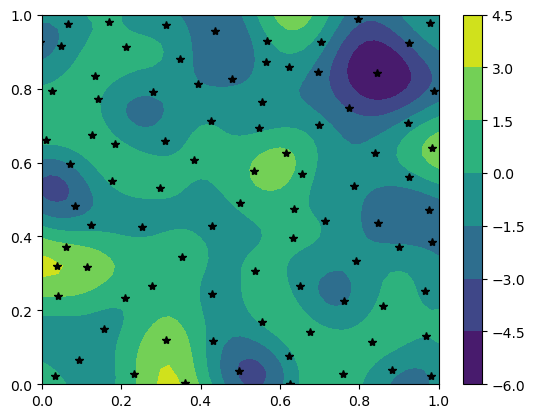

In [12]:
# Now making predictions on a finer grid
# Setting up the grid
n = 51
x1_test = torch.linspace(0,1,n)
x2_test = torch.linspace(0,1,n)
x1_test_grid, x2_test_grid = torch.meshgrid(x1_test,x2_test,indexing='ij')
X1_test = x1_test_grid.reshape(-1)
X2_test = x2_test_grid.reshape(-1)
X_test = torch.stack([X1_test,X2_test],dim=-1)
X_test_flipped = torch.stack([X2_test,X1_test],dim=-1)


# Get model into eval mode
model.eval()
likelihood.eval()

# Predicting
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))
    observed_pred_flipped = likelihood(model(X_test_flipped))


# Testing if predictions are equal
mean = observed_pred.mean
mean_flipped = observed_pred_flipped.mean
print(torch.equal(mean,mean_flipped)) # This returns True

# Plotting 
plt.contourf(x1_test_grid.numpy(),x2_test_grid.numpy(),mean.reshape(x1_test_grid.shape))
plt.colorbar()
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(model.variational_strategy.inducing_points.detach()[:,0],model.variational_strategy.inducing_points.detach()[:,1],'k*')

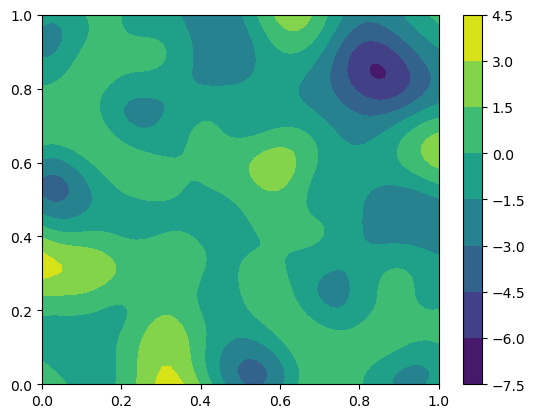

In [13]:
# Versus the true function

plt.contourf(x1_grid.numpy(),x2_grid.numpy(),f.reshape(x1_grid.shape))
plt.colorbar()
#plt.plot(X[:,0],X[:,1],'k*')

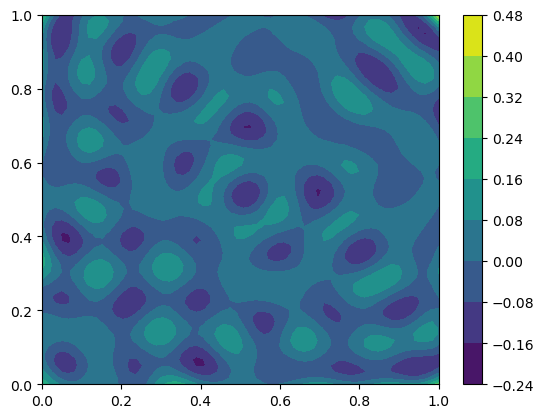

In [14]:
# And finally, let's look at the error surface
X_train_test = torch.stack([X1,X2],dim=-1)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_at_train = likelihood(model(X_train_test))

mean = test_at_train.mean
error = f-mean
plt.contourf(x1_grid.numpy(),x2_grid.numpy(),error.reshape(x1_grid.shape))
plt.colorbar()

### A more general version for any permutatation $\sigma(\{1,\ldots,p\})$

The permutation can be specified as a vector. For example $(4,1,2,5,3,0)$ is a permutation of the set $\{0,1,2,3,4,5\}$. We can use `torch.index_select` to permute the columns of the input matrix $X$ like we need, see below.

In [15]:
import torch 
X = torch.randn(10,5)
indices = torch.tensor([4,1,2])
print(X)
print(torch.index_select(X,1,indices)) # Pulls out the column in correct order

tensor([[ 0.3616,  0.2434,  0.7772,  0.2258,  1.6803],
        [-0.2514,  0.7673,  1.5144,  0.0951, -2.0619],
        [ 0.8633, -1.0172,  1.4618,  0.2709,  0.5450],
        [ 1.4013, -1.8792,  0.8065,  0.0204,  0.9394],
        [ 0.0585, -1.0583, -2.2245, -0.8747,  0.5701],
        [-1.9556,  0.2427, -0.1834,  0.5445,  0.7925],
        [-0.0564, -0.9754, -1.0362, -0.7920,  1.4872],
        [-2.0501, -0.7026,  0.7014, -0.0523, -0.2731],
        [ 0.3813, -0.2120,  0.8178, -0.8097, -0.2876],
        [-0.2303,  0.3279, -0.1990, -0.2315, -1.4392]])
tensor([[ 1.6803,  0.2434,  0.7772],
        [-2.0619,  0.7673,  1.5144],
        [ 0.5450, -1.0172,  1.4618],
        [ 0.9394, -1.8792,  0.8065],
        [ 0.5701, -1.0583, -2.2245],
        [ 0.7925,  0.2427, -0.1834],
        [ 1.4872, -0.9754, -1.0362],
        [-0.2731, -0.7026,  0.7014],
        [-0.2876, -0.2120,  0.8178],
        [-1.4392,  0.3279, -0.1990]])


We can build a more general version of `PermutationInvariantVariationalStrategy` that does this for us, it takes as input an additional argument `permutation` which is a `torch.tensor` of integers that specifies the permutation the function should be invariant to.

In [16]:
# Lets first set up our own Variational Strategy, just so we can see the flow of things:
# just copy and paste in the default one with a new name:
from typing import  Any, Dict, Iterable, Optional, Tuple
from torch import Tensor
from linear_operator import to_dense
from linear_operator.operators import (
    CholLinearOperator,
    DiagLinearOperator,
    LinearOperator,
    MatmulLinearOperator,
    RootLinearOperator,
    SumLinearOperator,
    TriangularLinearOperator,
)
from linear_operator.utils.cholesky import psd_safe_cholesky
from linear_operator.utils.errors import NotPSDError
from gpytorch.distributions import MultivariateNormal
from gpytorch.settings import _linalg_dtype_cholesky, trace_mode

def _ensure_updated_strategy_flag_set(
    state_dict: Dict[str, Tensor],
    prefix: str,
    local_metadata: Dict[str, Any],
    strict: bool,
    missing_keys: Iterable[str],
    unexpected_keys: Iterable[str],
    error_msgs: Iterable[str],
):
    device = state_dict[list(state_dict.keys())[0]].device
    if prefix + "updated_strategy" not in state_dict:
        state_dict[prefix + "updated_strategy"] = torch.tensor(False, device=device)
        warnings.warn(
            "You have loaded a variational GP model (using `VariationalStrategy`) from a previous version of "
            "GPyTorch. We have updated the parameters of your model to work with the new version of "
            "`VariationalStrategy` that uses whitened parameters.\nYour model will work as expected, but we "
            "recommend that you re-save your model.",
            OldVersionWarning,
        )

class PermutationInvariantVariationalStrategy(gpytorch.variational.VariationalStrategy):
    def __init__(self,
        model: gpytorch.models.ApproximateGP,
        inducing_points: torch.Tensor,
        variational_distribution: gpytorch.variational._VariationalDistribution,
        permutation: torch.Tensor,
        learn_inducing_locations: bool = True,
        jitter_val: Optional[float] = None,
    ):
        super().__init__(
            model, inducing_points, variational_distribution, learn_inducing_locations, jitter_val=jitter_val
        )
        self.register_buffer("updated_strategy", torch.tensor(True))
        self._register_load_state_dict_pre_hook(_ensure_updated_strategy_flag_set)
        self.has_fantasy_strategy = True
        ## TODO add a check to see if permutation is valid
        self.permutation = permutation
    
    def forward(
        self,
        x: Tensor,
        inducing_points: Tensor,
        inducing_values: Tensor,
        variational_inducing_covar: Optional[LinearOperator] = None,
        **kwargs,
    ) -> MultivariateNormal:
        print("x.shape")
        print(x.shape)
        print("torch.index_select(x, 1, self.permutation).shape")
        print(torch.index_select(x, 1, self.permutation).shape)
        # Compute full prior distribution
        full_inputs = torch.cat([inducing_points, x, torch.index_select(x,1,self.permutation)], dim=-2)
        #full_inputs_flipped = torch.cat([inducing_points, torch.index_select(x,1,self.permutation)],dim=-2)        
        #full_inputs_flipped_flipped = torch.cat([x,torch.index_select(x,1,self.permutation)],dim=-2)
        full_output = self.model.forward(full_inputs, **kwargs)
        #full_output_flipped = self.model.forward(full_inputs_flipped, **kwargs)
        #full_output_flipped_flipped = self.model.forward(full_inputs_flipped_flipped, **kwargs)
        full_covar = full_output.lazy_covariance_matrix
        #full_covar_flipped = full_output_flipped.lazy_covariance_matrix
        #full_covar_flipped_flipped = full_output_flipped_flipped.lazy_covariance_matrix

        # Covariance terms
        num_induc = inducing_points.size(-2)
        num_x = x.size(-2)
        print("X.size(-2)")
        print(num_x)
        print("num_induc")
        print(num_induc)
        print("full_covar[..., :num_induc, num_induc:(num_induc + num_x)].shape")
        print(full_covar[..., :num_induc, num_induc:(num_induc + num_x)].shape)
        print("full_covar[..., :num_induc, (num_induc + num_x):].shape")
        print(full_covar[..., :num_induc, (num_induc + num_x):].shape)
        print("full_covar.shape")
        print(full_covar.shape)
        test_mean = full_output.mean[..., num_induc:(num_induc+num_x)]
        induc_induc_covar = full_covar[..., :num_induc, :num_induc].add_jitter(self.jitter_val)
        #induc_data_covar = full_covar[..., :num_induc, num_induc:].to_dense()
        induc_data_covar = (full_covar[..., :num_induc, num_induc:(num_induc+num_x)] + 
                            full_covar[..., :num_induc, (num_induc+num_x):]).to_dense()
        #data_data_covar = full_covar[..., num_induc:, num_induc:]
        data_data_covar = (full_covar[..., num_induc:(num_induc+num_x), num_induc:(num_induc+num_x)] +
                           full_covar[..., num_induc:(num_induc+num_x), (num_induc+num_x):] +
                           full_covar[..., (num_induc+num_x):, num_induc:(num_induc+num_x)] +
                           full_covar[..., (num_induc+num_x):, (num_induc+num_x):])

        # Compute interpolation terms
        # K_ZZ^{-1/2} K_ZX
        # K_ZZ^{-1/2} \mu_Z
        L = self._cholesky_factor(induc_induc_covar)
        if L.shape != induc_induc_covar.shape:
            # Aggressive caching can cause nasty shape incompatibilies when evaluating with different batch shapes
            # TODO: Use a hook fo this
            try:
                pop_from_cache_ignore_args(self, "cholesky_factor")
            except CachingError:
                pass
            L = self._cholesky_factor(induc_induc_covar)
        interp_term = L.solve(induc_data_covar.type(_linalg_dtype_cholesky.value())).to(full_inputs.dtype)

        # Compute the mean of q(f)
        # k_XZ K_ZZ^{-1/2} (m - K_ZZ^{-1/2} \mu_Z) + \mu_X
        predictive_mean = (interp_term.transpose(-1, -2) @ inducing_values.unsqueeze(-1)).squeeze(-1) + test_mean

        # Compute the covariance of q(f)
        # K_XX + k_XZ K_ZZ^{-1/2} (S - I) K_ZZ^{-1/2} k_ZX
        middle_term = self.prior_distribution.lazy_covariance_matrix.mul(-1)
        if variational_inducing_covar is not None:
            middle_term = SumLinearOperator(variational_inducing_covar, middle_term)

        if trace_mode.on():
            predictive_covar = (
                data_data_covar.add_jitter(self.jitter_val).to_dense()
                + interp_term.transpose(-1, -2) @ middle_term.to_dense() @ interp_term
            )
        else:
            predictive_covar = SumLinearOperator(
                data_data_covar.add_jitter(self.jitter_val),
                MatmulLinearOperator(interp_term.transpose(-1, -2), middle_term @ interp_term),
            )

        # Return the distribution
        return MultivariateNormal(predictive_mean, predictive_covar)

Now let's set up a function that is symmetric in two of it's arguments, but not in the others. For example,
$$
f(x_1,x_2,x_3,x_4) = f(x_2,x_1,x_3,x_4)
$$

which is symmetric in $(x_1,x_2)$ but not in $(x_3,x_4)$

In [17]:
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

# Setting up the grid
n = 11
x1 = torch.linspace(0,1,n)
x2 = torch.linspace(0,1,n)
x3 = torch.linspace(0,1,n)
x4 = torch.linspace(0,1,n)
x1_grid, x2_grid, x3_grid, x4_grid = torch.meshgrid(x1,x2,x3,x4,indexing='ij')
X1 = x1_grid.reshape(-1)
X2 = x2_grid.reshape(-1)
X3 = x3_grid.reshape(-1)
X4 = x4_grid.reshape(-1)
X = torch.stack([X1,X2,X3,X4],dim=-1)
X_flipped = torch.stack([X2,X1,X3,X4],dim=-1)

# Generating a random sample from a GP
mean = gpytorch.means.ZeroMean()
covar = gpytorch.kernels.RBFKernel()
covar.lengthscale = 0.1
m = mean(X)
K = (covar(X,X) + covar(X,X_flipped) + covar(X_flipped,X) + covar(X_flipped,X_flipped)).add_jitter().evaluate()
GP = gpytorch.distributions.MultivariateNormal(m,K)
f = GP.rsample().detach()


# Now generate some corresponding data
sigma = 0.01
y = f + sigma*torch.randn(f.size())


# Finally, going to drop a proportion of the data just to ensure the grid structure is broken and 
# the model will find it difficult to learn the exact invariance.
k = 2000
perm = torch.randperm(y.size(0))
idx = perm[:k]
y = y[idx]
X = X[idx,:]





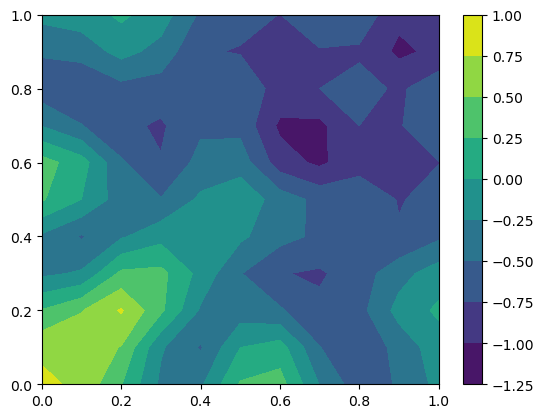

In [18]:
# Do plotting here so we don't generate a new sample everytime
# These plots should look symmetric
slice3 = 5
slice4 = 0
plt.contourf(x1_grid[:,:,slice3,slice4].numpy(),x2_grid[:,:,slice3,slice4].numpy(),f.reshape(x1_grid.shape)[:,:,slice3,slice4])
plt.colorbar()

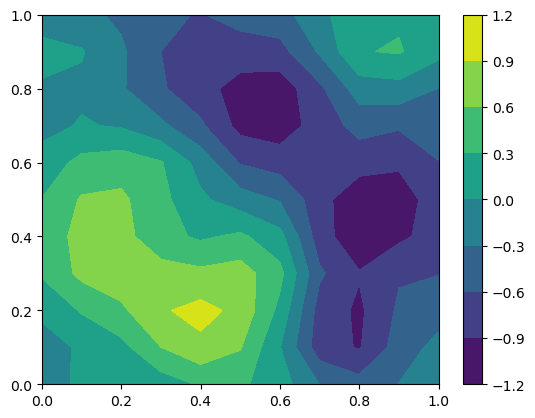

In [19]:
# Do plotting here so we don't generate a new sample everytime
# These should not necessarily be symmetric
slice1 = 6
slice2 = 0
plt.contourf(x3_grid[slice1,slice2,:,:].numpy(),x4_grid[slice1,slice2,:,:].numpy(),f.reshape(x3_grid.shape)[slice1,slice2,:,:])
plt.colorbar()

In [20]:
X.shape

torch.Size([2000, 4])

Set up the model and keep in mind to define the permutation

In [21]:
# And now define the approximate model, nothing invariant going on here
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        permutation = torch.tensor([1,0,2,3])
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = PermutationInvariantVariationalStrategy(self,inducing_points,variational_distribution,
                                                                       permutation=permutation,
                                                                       learn_inducing_locations=True)
        super(GPModel,self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)
    
num_inducing_points = 500
inducing_points = torch.rand(num_inducing_points,4)
model = GPModel(inducing_points=inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [22]:
# Set up optimization scheme

# Number of iterations of optimizer
training_iter = 1

# Set model in train
model.train()
likelihood.train()
# Optimizeer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.005)
# Define loss function
mll = gpytorch.mlls.VariationalELBO(likelihood,model,num_data = y.size(0))

# Keeping track of loss
m = []
eps = 1e-6
diff = 10

# Then train
for i in range(training_iter):
    # Zero gradients
    optimizer.zero_grad()
    # Output from model 
    output = model(X)
    # Calculate loss
    loss = -mll(output,y)
    loss.backward()
    m.append(loss.item())
    if i > 0:
        diff = abs(m[i]-m[i-1])
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f loss difference: %.4f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        likelihood.noise.item(),
        diff
    ))
    optimizer.step()
    if diff < eps:
        print('Model converged!')
        break

x.shape
torch.Size([2000, 4])
torch.index_select(x, 1, self.permutation).shape
torch.Size([2000, 4])
X.size(-2)
2000
num_induc
500
full_covar[..., :num_induc, num_induc:(num_induc + num_x)].shape
torch.Size([500, 2000])
full_covar[..., :num_induc, (num_induc + num_x):].shape
torch.Size([500, 2000])
full_covar.shape
torch.Size([4500, 4500])
Iter 1/1 - Loss: 2.756   lengthscale: 0.693   noise: 0.693 loss difference: 10.0000


In [44]:
# Now making predictions on a finer grid
# Setting up the grid
n = 21
x1_test = torch.linspace(0,1,n)
x2_test = torch.linspace(0,1,n)
x3_test = torch.linspace(0,1,n)
x4_test = torch.linspace(0,1,n)
x1_test_grid, x2_test_grid, x3_test_grid, x4_test_grid = torch.meshgrid(x1_test,x2_test,x3_test,x4_test,indexing='ij')
X1_test = x1_test_grid.reshape(-1)
X2_test = x2_test_grid.reshape(-1)
X3_test = x3_test_grid.reshape(-1)
X4_test = x4_test_grid.reshape(-1)
X_test = torch.stack([X1_test,X2_test,X3_test,X4_test],dim=-1)
X_test_flipped = torch.stack([X2_test,X1_test,X3_test,X4_test],dim=-1)


# Get model into eval mode
model.eval()
likelihood.eval()

# Predicting
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))
    observed_pred_flipped = likelihood(model(X_test_flipped))


# Testing if predictions are equal
mean = observed_pred.mean
mean_flipped = observed_pred_flipped.mean
print(torch.equal(mean,mean_flipped)) # This returns True


True


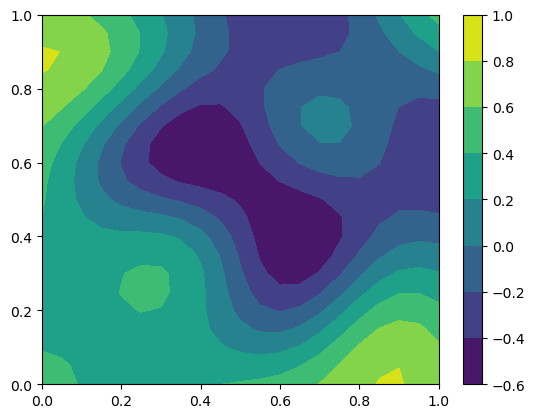

In [45]:
# Plotting 
# These plots should look symmetric
slice3 = 5
slice4 = 0
plt.contourf(x1_test_grid[:,:,slice3,slice4].numpy(),x2_test_grid[:,:,slice3,slice4].numpy(),mean.reshape(x1_test_grid.shape)[:,:,slice3,slice4])
plt.colorbar()
#plt.xlim(0,1)
#plt.ylim(0,1)
#plt.plot(model.variational_strategy.inducing_points.detach()[:,0],model.variational_strategy.inducing_points.detach()[:,1],'k*')

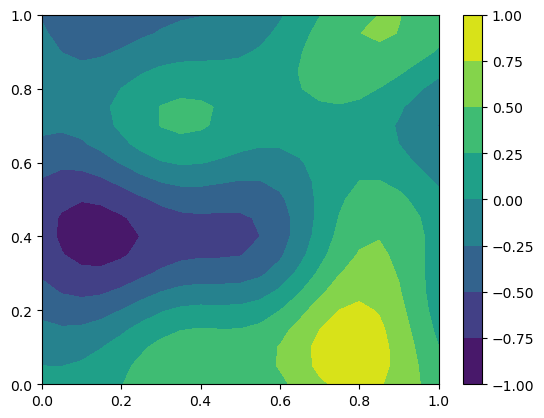

In [46]:
# These should not necessarily be symmetric
slice1 = 6
slice2 = 0
plt.contourf(x3_test_grid[slice1,slice2,:,:].numpy(),x4_test_grid[slice1,slice2,:,:].numpy(),mean.reshape(x3_test_grid.shape)[slice1,slice2,:,:])
plt.colorbar()